# Post-processing 

## Import and data loading

In [54]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, time
import gzip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
from pandas import json_normalize

In [55]:
LOCAL = 'Avenches'
# LOCAL = 'Lausanne'
group_to_type = {
    0: 'home',
    1: 'education',
    2: 'work',
    3: 'leisure',
    4: 'shop'
}
HORIZON = 289

In [56]:
activity_csv = pd.read_csv("Data/PreProcessed/activity.csv")
population_csv = pd.read_csv("Data/PreProcessed/population.csv")
NUM_ACTIVITIES = len(activity_csv) + 3   

In [57]:
activity_file = 'Data/Original/vaud_activities.csv.gz'
population_file = 'Data/Original/vaud_population.csv.gz'
trip_file = 'Data/Original/vaud_trips.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

activity_vaud_full = read_gzipped_csv(activity_file)
activity_vaud = activity_vaud_full[activity_vaud_full['type'] != 'pt interaction']
population_vaud = read_gzipped_csv(population_file)[['id', 'age', 'home_x', 'home_y', 'local']]
# trip_vaud = read_gzipped_csv(trip_file)[['Unnamed: 0', 'id', 'mode', 'dep_time','trav_time','start_link','end_link']].drop_duplicates()

## Functions :

In [58]:
# https://matplotlib.org/stable/gallery/color/named_colors.html 
color_palette = {
    'home': 'royalblue',       
    'work': 'gold',     
    'leisure': 'lightpink', # RGB tuple, each value must be in the range [0, 1]
    'shop': 'aquamarine', 
    'transport': 'silver',   
    'pt interaction': 'grey',
    'other': 'mediumvioletred',
    'education': 'teal',
}

In [59]:
def plot_schedule_dataset(activity_df, individual_id):
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    
    segments = []
    colors = []
    fig, ax = plt.subplots(figsize=(10, 1))
    
    start_of_day = datetime.strptime('00:00:00', '%H:%M:%S')
    end_of_day = datetime.strptime('23:59:59', '%H:%M:%S')
    prev_end = start_of_day
    
    for _, facility in individual_schedule.iterrows():
        start_time = datetime.strptime(facility['start_time'], '%H:%M:%S') if pd.notna(facility['start_time']) else start_of_day
        end_time = datetime.strptime(facility['end_time'], '%H:%M:%S') if pd.notna(facility['end_time']) else end_of_day
        
        if prev_end < start_time:
            segments.append([(prev_end - start_of_day).total_seconds() / 3600, (start_time - prev_end).total_seconds() / 3600])
            colors.append(color_palette['transport'])
            ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
            
        segments.append([(start_time - start_of_day).total_seconds() / 3600, (end_time - start_time).total_seconds() / 3600])
        colors.append(color_palette[facility['type']])
        ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
        
        prev_end = end_time


    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlim(0, 24)
    ax.set_yticks([])
    ax.set_xticks(range(25))
    ax.set_xlabel('Original schedule')
    plt.show()

In [60]:
def plot_schedule_json(df, individual_id):
    individual_schedule = df[df['id'] == individual_id].sort_values(by='start')
    
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xticks(range(0, 25, 1))
    ax.set_xlabel(f"Predicted schedule (U={individual_schedule.iloc[0]['utility']:.1f})")
    
    # Convert time objects to hours since the start of the day
    time_to_hours = lambda t: t.hour + t.minute / 60 + t.second / 3600
    
    prev_end_time = time_to_hours(datetime.strptime('00:00:00', '%H:%M:%S').time())
    
    # Iterate over the activities
    for _, activity in individual_schedule.iterrows():
        start_time = time_to_hours(activity['start'])
        end_time = time_to_hours(activity['end_time'])
        
        # If there is a gap between the previous end time and the current start time, plot it as 'transport'
        if prev_end_time < start_time:
            ax.broken_barh([(prev_end_time, start_time - prev_end_time)], (0, 1), facecolors=color_palette['transport'])
        
        ax.broken_barh([(start_time, end_time - start_time)], (0, 1), facecolors=color_palette[activity['group']])
        
        prev_end_time = end_time

    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [61]:
def print_schedule(activity_df, individual_id):
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    print(tabulate(individual_schedule, headers='keys', tablefmt='pipe'))

In [62]:
def compare_individual_schedules(df_dataset, df_json, individual_id, table=True, plot=True):
    if table: 
        print("Here is his/her schedule in the original dataset :\n")
        print_schedule(df_dataset, individual_id)
    if plot:
        plot_schedule_dataset(df_dataset, individual_id)
    if table:
        print("Here is his/her schedule with our planning algorythm :\n")
        print_schedule(df_json, individual_id)
    if plot:
        plot_schedule_json(df_json, individual_id)

In [63]:
def horizons_to_timedelta(n):
    minutes = n * 5
    time_delta = timedelta(minutes=minutes)
    return time_delta

In [64]:
def json_to_flat_dataframe(json_path):
    with open(json_path, 'r') as file:
        data = pd.read_json(file)
    
    # Normalize the 'daily_schedule' data to create a flat table
    # We will concatenate all the schedules along with their top-level data such as 'id', 'execution_time', etc.
    flat_data = pd.DataFrame()  # Empty dataframe to hold our flattened data
    for record in data.to_dict(orient='records'):
        # Normalize the daily_schedule for each record
        schedule_df = json_normalize(record, 'daily_schedule', errors='ignore')
        
        # Adding the top-level data as new columns to the schedule_df
        for col in data.columns.difference(['daily_schedule']):
            schedule_df[col] = record[col]
        
        # Append to the flat_data DataFrame
        flat_data = pd.concat([flat_data, schedule_df], ignore_index=True)
    
    return flat_data

In [65]:
def minutes_to_time2(minute_value):
    total_minutes = minute_value * 5
    hours, minutes = divmod(total_minutes, 60)
    if hours >= 24:
        hours = hours % 24
    return time(hour=int(hours), minute=int(minutes))

In [66]:
def filter_and_sort_activities(df):
    # Convert 'start' and 'duration' from time objects to timedeltas for comparison
    df['duration_td'] = df['duration'].apply(lambda x: pd.to_timedelta(x.strftime('%H:%M:%S')))
    
    # Group by 'acity' and find the index of the row with the maximum duration
    idx = df.groupby(['acity', 'id', 'start'])['duration_td'].idxmax()
    
    # Select only the rows with the maximum duration
    max_duration_df = df.loc[idx]
    
    # Drop the auxiliary 'duration_td' column
    max_duration_df = max_duration_df.drop(columns=['duration_td'])
    
    # Now, sort the resulting DataFrame by the 'start' column
    max_duration_df = max_duration_df.sort_values(by='start', ascending = True)
    
    return max_duration_df

In [67]:
# Helper function to convert a time object to minutes
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# Helper function to convert minutes to a time object
def minutes_to_time(minutes):
    hours, minutes = divmod(minutes, 60)
    return time(hour=hours, minute=minutes)

# Function to calculate the end time of activities
def calculate_end_time(row):

    start_minutes = time_to_minutes(row['start'])
    duration_minutes = time_to_minutes(row['duration'])
    end_minutes = start_minutes + duration_minutes

    # Handle the special case for the last row
    if end_minutes >= 1440:
        return time(23, 59, 0)

    return minutes_to_time(end_minutes)

In [68]:
def reorder_df(df):
    new_order = [
        'acity', 'facility', 'group', 'start', 'duration', 'end_time', 'time',
        'cum_utility', 'DSSR_iterations', 'execution_time', 'id', 'utility'
    ]
    df = df[new_order]
    return df

In [69]:
def process_schedules_json(df): 
    ''' To apply on json file output by the algo 
    Return clean dataframe all schedules '''
    
    df['start'] = df['start'].apply(minutes_to_time2)
    df['duration'] = df['duration'].apply(minutes_to_time2)
    df['time'] = df['time'].apply(minutes_to_time2)

    filtered_df = filter_and_sort_activities(df)

    filtered_df['end_time'] = filtered_df.apply(calculate_end_time, axis=1)

    schedule_postprocessed = reorder_df(filtered_df)

    return schedule_postprocessed


In [70]:
def get_hours_list(row):
    ''' Function to create list of hours covered by the activity '''
    start_hour = row['start_datetime'].hour
    end_hour = row['end_datetime'].hour + (1 if row['end_datetime'].minute > 0 else 0)  # adjust if minutes > 0
    return list(range(start_hour, end_hour))

## Data cleaning

In [71]:
path_to_json_file = "Data/Generated/schedules.json"
results = json_to_flat_dataframe(path_to_json_file)
results_clean = process_schedules_json(results)
# print(set(df['id']))
# df.head()


 SCHEDULE OF INDIVIDUAL 6682627 (n*0) 



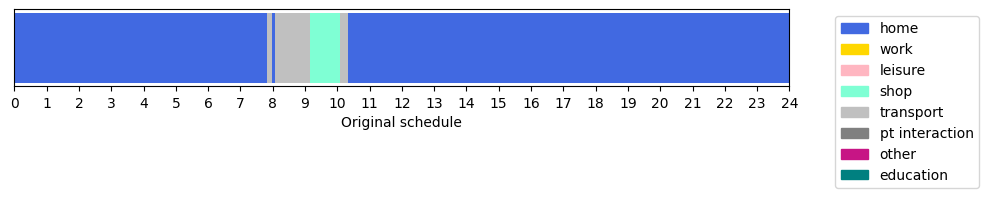

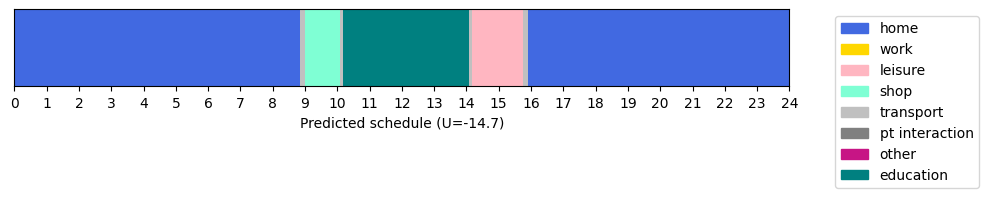

In [72]:
for index, id in enumerate(set(results_clean['id'])):
    if index == 1:
        break
    print(f"\n SCHEDULE OF INDIVIDUAL {id} (n*{index}) \n")
    compare_individual_schedules(activity_vaud, results_clean, id, table=False, plot=True)

In [73]:
# id = 6732548 
# compare_individual_schedules(activity_vaud, results_clean, id, table=True, plot=True)

In [74]:
pd.options.mode.chained_assignment = None  # default='warn'
sample_pop = pd.read_csv("Data/PreProcessed/population.csv")
sample_ids = sample_pop['id']
orig_sched_samp = activity_vaud[activity_vaud['id'].isin(sample_ids)] 
orig_sched_samp_filt = orig_sched_samp[~orig_sched_samp['type'].isin(['pt interaction', 'home'])] # pas filtrer others pour la coherence
# peut etre filtrer les temps superieurs a 24h ? 
# cf preprocessing
orig_sched_samp_filt.loc[:, 'start_datetime'] = pd.to_datetime(
    orig_sched_samp_filt['start_time'], 
    errors='coerce', 
    format='%H:%M:%S' 
).fillna(pd.Timestamp('1900-01-01 00:00:00'))

orig_sched_samp_filt.loc[:, 'end_datetime'] = pd.to_datetime(
    orig_sched_samp_filt['end_time'], 
    errors='coerce', 
    format='%H:%M:%S'  
).fillna(pd.Timestamp('1900-01-01 23:59:00'))

orig_sched_samp_filt['duration'] = orig_sched_samp_filt['end_datetime'] - orig_sched_samp_filt['start_datetime']

# orig_sched_samp_filt.head()

In [75]:
def construct_observed_ToD_activity_frequency(df, col_name):
    if col_name == 'group':
        df = df[df[col_name] != 'home']

    # Apply the function and create a new 'hours' column
    pd.options.mode.chained_assignment = None  # default='warn'
    df.loc[:, 'hours'] = df.apply(get_hours_list, axis=1)

    # Explode 'hours' so each hour is a separate row
    df_hours_exploded = df.explode('hours')

    # Count occurrences
    hour_activity_count = df_hours_exploded.groupby(['hours', col_name]).size().unstack(fill_value=0)
    all_hours = pd.Index(range(24), name='hours')
    hour_activity_count = hour_activity_count.reindex(all_hours, fill_value=0)

    # Calculate proportions
    total_people = df['id'].nunique()
    hour_activity_proportion = hour_activity_count.div(total_people)

    return hour_activity_proportion

In [76]:
def plot_observed_ToD_activity_frequency(df):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Construire une liste de couleurs basée sur les colonnes actuelles du DataFrame
    column_colors = [color_palette.get(activity, 'gray') for activity in df.columns]

    # Create a stacked bar chart
    df.plot(kind='bar', stacked=True, ax=ax, color=column_colors)

    ax.set_title('Distribution (data)')
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Proportion')

    plt.xticks(ticks=range(24), labels=[f'{hour}:00' for hour in range(24)], rotation=0)
    ax.legend(title='Activity Type', loc='upper right', bbox_to_anchor=(1.0, 1.0))
    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

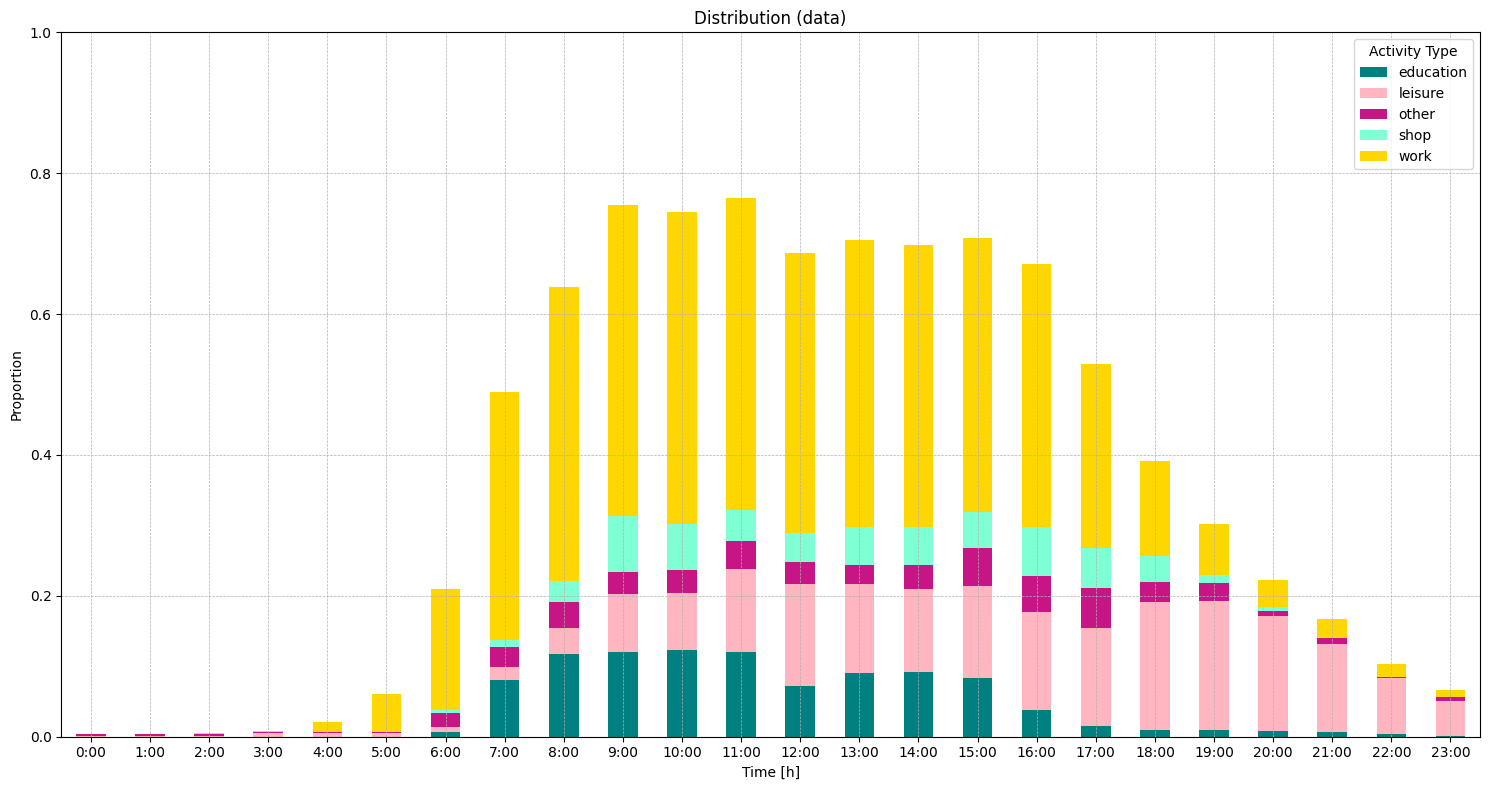

In [77]:
hour_activity_proportion = construct_observed_ToD_activity_frequency(orig_sched_samp_filt, 'type')
plot_observed_ToD_activity_frequency(hour_activity_proportion)

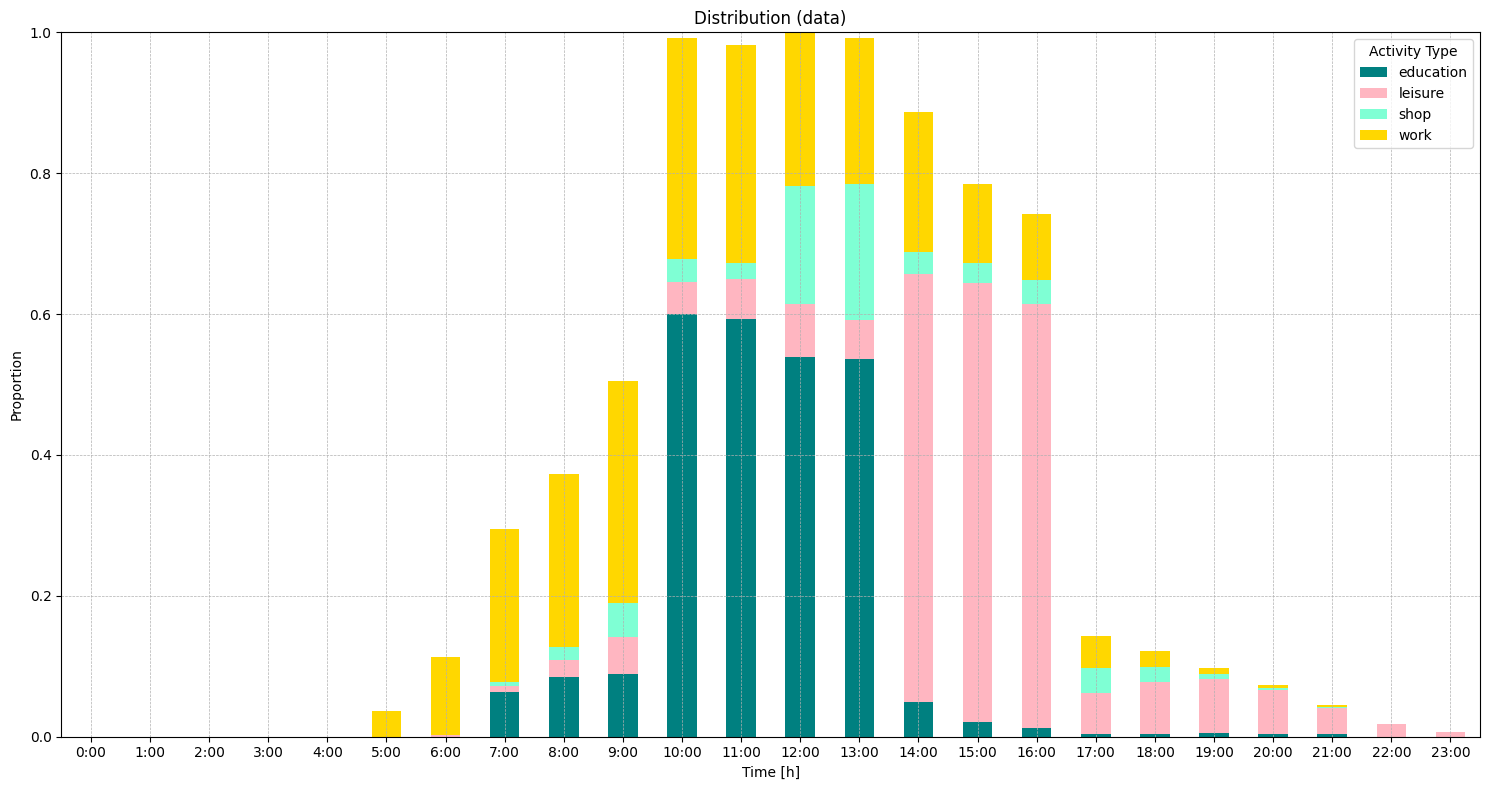

In [78]:
results_clean.loc[:, 'start_datetime'] = pd.to_datetime(
    results_clean['start'], 
    errors='coerce', 
    format='%H:%M:%S' 
).fillna(pd.Timestamp('1900-01-01 00:00:00'))
results_clean.loc[:, 'end_datetime'] = pd.to_datetime(
    results_clean['end_time'], 
    errors='coerce', 
    format='%H:%M:%S'  
).fillna(pd.Timestamp('1900-01-01 23:59:00'))

hour_activity_proportion_2 =construct_observed_ToD_activity_frequency(results_clean, 'group')
plot_observed_ToD_activity_frequency(hour_activity_proportion_2)

In [79]:
def time_to_timedelta(t):
    if pd.isnull(t):
        return pd.Timedelta(seconds=0)
    return pd.Timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

def calculate_mean_duration_hm(df, col_name, p=False):
    
    # Calculate the mean duration by type as total seconds
    if col_name == 'group':
        df['duration'] = df['duration'].apply(time_to_timedelta)
    mean_duration_by_type = df.groupby(col_name)['duration'].mean()
    
    # Convert the mean duration to the format 'HH:MM'
    mean_duration_by_type_hm = mean_duration_by_type.apply(
        lambda x: f"{int(x.total_seconds() // 3600):02d}:{int((x.total_seconds() % 3600) // 60):02d}"
    )

    if p:
        print(mean_duration_by_type_hm)
    
    return mean_duration_by_type_hm

In [80]:
calculate_mean_duration_hm(orig_sched_samp_filt, 'type', p=True)
calculate_mean_duration_hm(results_clean, 'group')

type
education    04:04
leisure      01:56
other        00:30
shop         00:31
work         04:51
Name: duration, dtype: object


group
education    03:45
home         03:38
leisure      01:34
shop         00:39
work         05:36
Name: duration, dtype: object

In [81]:
def calculate_activity_proportions(df, col_type_name, p=False):
    # Filter the DataFrame for relevant activity types if needed
    activity_types = ['shop', 'leisure', 'work', 'education']
    filtered_df = df[df[col_type_name].isin(activity_types)]
    
    # Group by 'id' and 'type' and check if the activity exists in the schedule
    activity_by_individual = filtered_df.groupby(['id', col_type_name]).size().unstack(fill_value=0)
    
    # Now check for the presence of each activity, result is boolean
    activity_presence = activity_by_individual > 0

    # Calculate the proportion of individuals that have each activity
    activity_proportions = activity_presence.mean()
    
    # Convert the proportions to a DataFrame for nice formatting
    proportions_df = activity_proportions
    proportions_df.columns = ['Activity Type', 'Proportion']
    
    if p: 
        print(proportions_df)
        
    return proportions_df


In [82]:
calculate_activity_proportions(orig_sched_samp_filt, 'type', p=True)
calculate_activity_proportions(results_clean, 'group')

type
education    0.139085
leisure      0.508803
shop         0.367958
work         0.514085
dtype: float64


group
education    0.60875
leisure      0.89000
shop         0.35750
work         0.38250
dtype: float64

# In work